# A/B Testing Framework: E-Commerce Checkout Optimization

## 1. Business Problem
An e-commerce platform wants to improve its checkout conversion rate. The current checkout process is a multi-step flow. The product team has developed a new, simplified one-page checkout. 

**Hypothesis:** Simplifying the checkout process to a single page will reduce friction, thereby increasing the overall conversion rate (CR) and potentially the average order value (AOV).

**Test Design:**
- **Control Group:** Users exposed to the existing multi-step checkout.
- **Treatment Group:** Users exposed to the new one-page checkout.
- **Metrics of Interest:** 
  1. Primary: Conversion Rate (CR)
  2. Secondary: Average Order Value (AOV)


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest

# Set plot style
sns.set_theme(style="whitegrid", palette="muted")
import warnings
warnings.filterwarnings('ignore')


## 2. Data Loading & Initial Exploration
Let's load the generated synthetic dataset and inspect it.


In [2]:
# Load data
df = pd.read_csv('ab_test_data.csv')

# Display basic info
print(f"Dataset shape: {df.shape}")
display(df.head())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Dataset shape: (100000, 8)


,session_id,user_id,timestamp,group,landing_page,device,converted,order_value
0,S000001,U015796,2026-02-08 00:00:19,control,checkout_step_1,Desktop,0,NaN
1,S000002,U000861,2026-02-08 00:01:14,control,checkout_step_1,Desktop,0,NaN
2,S000003,U076821,2026-02-08 00:01:46,control,checkout_step_1,Desktop,0,NaN
3,S000004,U054887,2026-02-08 00:01:48,control,checkout_step_1,Mobile,0,NaN
4,S000005,U006266,2026-02-08 00:01:52,control,checkout_step_1,Mobile,0,NaN



Missing values per column:
session_id          0
user_id             0
timestamp           0
group               0
landing_page        0
device            100
converted           0
order_value     89827
dtype: int64


I notice a few missing values in the `device` column. Since it's a very small amount, I can safely drop these rows for device-specific analysis, or fill them with a placeholder. For my main analysis, I don't need to drop them unless I stratify by device. Let's drop rows with missing devices just to keep the dataset clean.


In [3]:
# Drop missing values
df.dropna(subset=['device'], inplace=True)
print(f"Dataset shape after dropping missing devices: {df.shape}")

# Deduplicate by user_id to ensure I only have one record per user (First touch approach)
# A/B tests typically analyze unique users to maintain independence of observations
df = df.sort_values('timestamp').drop_duplicates('user_id', keep='first')
print(f"Dataset shape after deduplicating users: {df.shape}")


Dataset shape after dropping missing devices: (99900, 8)
Dataset shape after deduplicating users: (61846, 8)


## 3. Data Quality & Sanity Checks

### 3.1 Sample Ratio Mismatch (SRM)
Before analyzing the results, I must ensure there was no Sample Ratio Mismatch (SRM). The user traffic should be split approximately 50/50. If there's a significant deviation, it indicates a bug in the randomization algorithm.


In [4]:
control_users = df[df['group'] == 'control'].shape[0]
treatment_users = df[df['group'] == 'treatment'].shape[0]
total_users = control_users + treatment_users

print(f"Control Users: {control_users} ({control_users/total_users:.2%})")
print(f"Treatment Users: {treatment_users} ({treatment_users/total_users:.2%})")

# Chi-Square Test for Goodness of Fit
# Expected is 50/50 split
expected = [total_users / 2, total_users / 2]
observed = [control_users, treatment_users]

chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)

print(f"\nChi-Square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("WARNING: SRM detected! The traffic split is significantly different from 50/50.")
else:
    print("SUCCESS: No Sample Ratio Mismatch (SRM) detected. I can proceed with analysis.")


Control Users: 30900 (49.96%)
Treatment Users: 30946 (50.04%)

Chi-Square Statistic: 0.0342
P-value: 0.8533
SUCCESS: No Sample Ratio Mismatch (SRM) detected. I can proceed with analysis.


### 3.2 Exploratory Data Analysis (EDA)
Let's visualize the baseline metrics across both groups.


,group,users,conversions,cr,avg_order_value
0,control,30900,3115,0.100809,65.070254
1,treatment,30946,3262,0.105409,67.566536


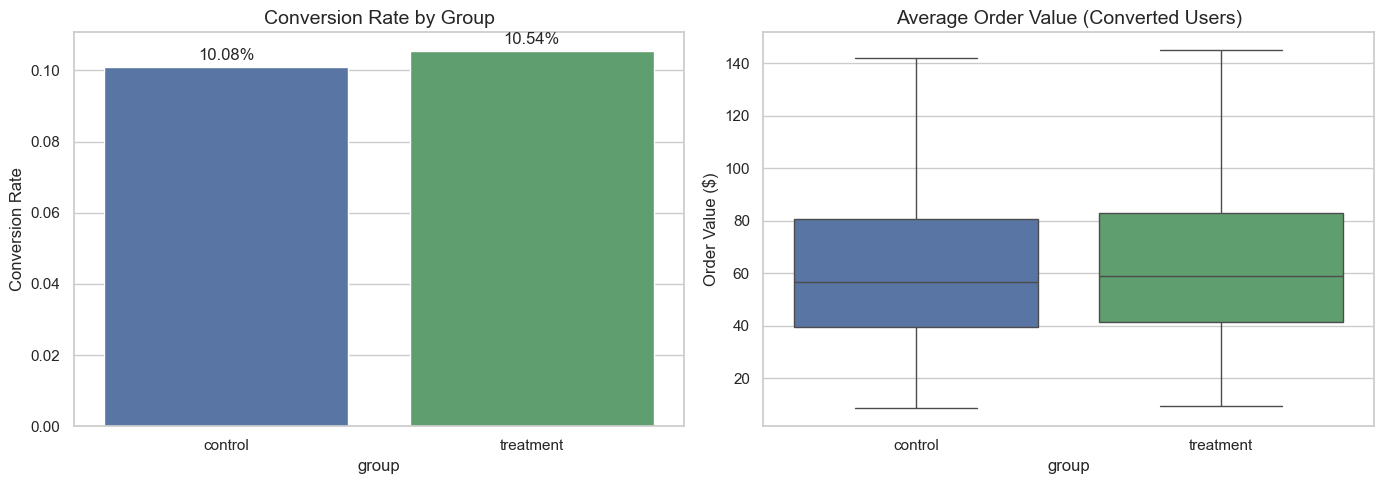

In [5]:
# Group by test variation
summary_stats = df.groupby('group').agg(
    users=('user_id', 'nunique'),
    conversions=('converted', 'sum'),
    cr=('converted', 'mean'),
    avg_order_value=('order_value', 'mean')
).reset_index()

display(summary_stats)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Conversion Rate
sns.barplot(x='group', y='cr', data=summary_stats, ax=axes[0], palette=['#4c72b0', '#55a868'])
axes[0].set_title('Conversion Rate by Group', fontsize=14)
axes[0].set_ylabel('Conversion Rate')
for i, v in enumerate(summary_stats['cr']):
    axes[0].text(i, v + 0.002, f"{v:.2%}", ha='center', fontsize=12)

# Plot Average Order Value
# Filter to only converted users
converted_df = df[df['converted'] == 1]
sns.boxplot(x='group', y='order_value', data=converted_df, ax=axes[1], palette=['#4c72b0', '#55a868'], showfliers=False)
axes[1].set_title('Average Order Value (Converted Users)', fontsize=14)
axes[1].set_ylabel('Order Value ($)')

plt.tight_layout()
plt.show()


## 4. Statistical Analysis: Hypothesis Testing

### 4.1 Primary Metric: Conversion Rate (Z-Test)
I use a two-proportion Z-test to evaluate if the difference in conversion rates between the treatment and control groups is statistically significant.

- **Null Hypothesis (H0):** $p_{treatment} - p_{control} \leq 0$ (The CR of the one-page checkout is equal to or less than the multi-step checkout).
- **Alternative Hypothesis (H1):** $p_{treatment} - p_{control} > 0$ (The CR of the one-page checkout is greater than the multi-step checkout).
- **Significance Level ($lpha$):** 0.05


In [6]:
control_conversions = summary_stats.loc[summary_stats['group'] == 'control', 'conversions'].values[0]
treatment_conversions = summary_stats.loc[summary_stats['group'] == 'treatment', 'conversions'].values[0]

n_control = summary_stats.loc[summary_stats['group'] == 'control', 'users'].values[0]
n_treatment = summary_stats.loc[summary_stats['group'] == 'treatment', 'users'].values[0]

successes = [treatment_conversions, control_conversions]
nobs = [n_treatment, n_control]

z_stat, p_val_cr = proportions_ztest(successes, nobs=nobs, alternative='larger')

cr_control = control_conversions / n_control
cr_treatment = treatment_conversions / n_treatment
relative_lift_cr = (cr_treatment - cr_control) / cr_control

print(f"Control CR: {cr_control:.4f}")
print(f"Treatment CR: {cr_treatment:.4f}")
print(f"Relative Uplift: {relative_lift_cr:.2%}\n")

print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value: {p_val_cr:.4e}")

if p_val_cr < 0.05:
    print("\nConclusion: Reject the null hypothesis. The treatment group has a statistically significant higher conversion rate.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. There is no statistically significant improvement in conversion rate.")


Control CR: 0.1008
Treatment CR: 0.1054
Relative Uplift: 4.56%

Z-statistic: 1.8810
P-value: 2.9984e-02

Conclusion: Reject the null hypothesis. The treatment group has a statistically significant higher conversion rate.


### 4.2 Secondary Metric: Average Order Value (T-Test)
Next, I evaluate whether the new checkout experience led to a change in Average Order Value among converted users.

- **Null Hypothesis (H0):** $\mu_{treatment} - \mu_{control} = 0$
- **Alternative Hypothesis (H1):** $\mu_{treatment} - \mu_{control} 
eq 0$
- **Significance Level ($lpha$):** 0.05


In [7]:
aov_control = df[(df['group'] == 'control') & (df['converted'] == 1)]['order_value']
aov_treatment = df[(df['group'] == 'treatment') & (df['converted'] == 1)]['order_value']

print(f"Control AOV: ${aov_control.mean():.2f}")
print(f"Treatment AOV: ${aov_treatment.mean():.2f}")

# Check variance
stat, p_levene = stats.levene(aov_control, aov_treatment)
print(f"Levene's Test for Equal Variances P-value: {p_levene:.4f}")

# Use Welch's t-test which does not assume equal population variance
t_stat, p_val_aov = stats.ttest_ind(aov_treatment, aov_control, equal_var=False)

print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_val_aov:.4f}")

if p_val_aov < 0.05:
    print("\nConclusion: Reject the null hypothesis. There is a statistically significant difference in Average Order Value.")
else:
    print("\nConclusion: Fail to reject the null hypothesis. No significant difference in AOV.")


Control AOV: $65.07
Treatment AOV: $67.57
Levene's Test for Equal Variances P-value: 0.5737

T-statistic: 2.6655
P-value: 0.0077

Conclusion: Reject the null hypothesis. There is a statistically significant difference in Average Order Value.


## 5. Segmentation Analysis
Are the effects consistent across different device types (Desktop vs. Mobile)? This is a critical question for product rollouts.


,Device,Control CR,Treatment CR,Relative Uplift,P-value,Significant
0,Desktop,12.31%,12.99%,5.47%,4.5689e-02,True
1,Mobile,8.05%,8.43%,4.75%,1.1059e-01,False
2,Tablet,10.08%,9.98%,-1.01%,5.3771e-01,False


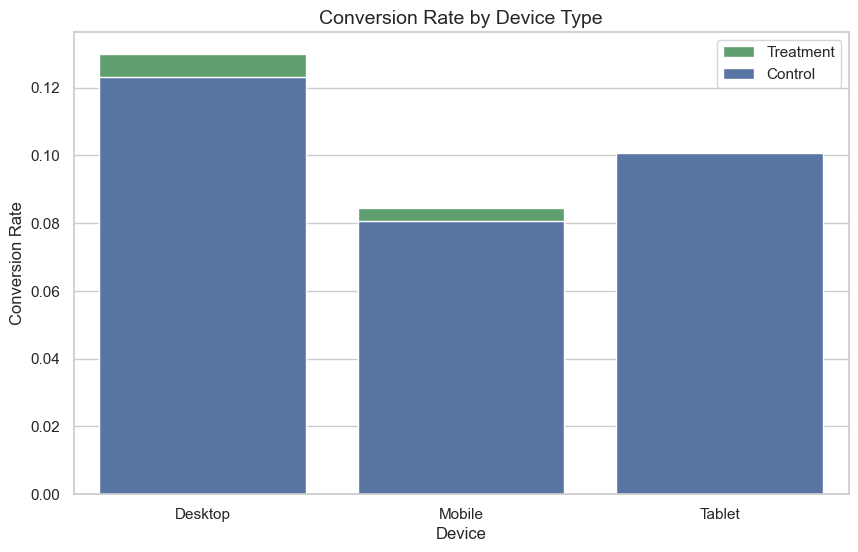

In [8]:
segments = df['device'].dropna().unique()

segment_results = []

for segment in segments:
    segment_df = df[df['device'] == segment]
    
    n_ctrl = segment_df[segment_df['group'] == 'control'].shape[0]
    n_trt = segment_df[segment_df['group'] == 'treatment'].shape[0]
    
    conv_ctrl = segment_df[(segment_df['group'] == 'control')]['converted'].sum()
    conv_trt = segment_df[(segment_df['group'] == 'treatment')]['converted'].sum()
    
    cr_ctrl = conv_ctrl / n_ctrl
    cr_trt = conv_trt / n_trt
    
    z_stat, p_val = proportions_ztest([conv_trt, conv_ctrl], nobs=[n_trt, n_ctrl], alternative='larger')
    
    segment_results.append({
        'Device': segment,
        'Control CR': cr_ctrl,
        'Treatment CR': cr_trt,
        'Relative Uplift': (cr_trt - cr_ctrl) / cr_ctrl,
        'P-value': p_val,
        'Significant': p_val < 0.05
    })

segment_df_res = pd.DataFrame(segment_results)
display(segment_df_res.style.format({
    'Control CR': '{:.2%}',
    'Treatment CR': '{:.2%}',
    'Relative Uplift': '{:.2%}',
    'P-value': '{:.4e}'
}))

# Plot segmentation
plt.figure(figsize=(10, 6))
sns.barplot(x='Device', y='Treatment CR', data=segment_df_res, color='#55a868', label='Treatment')
sns.barplot(x='Device', y='Control CR', data=segment_df_res, color='#4c72b0', label='Control')
plt.title('Conversion Rate by Device Type', fontsize=14)
plt.ylabel('Conversion Rate')
plt.legend()
plt.show()


## 6. Business Conclusion and Recommendations

### Key Findings:
1. **Conversion Rate (Primary Metric):** The one-page checkout (Treatment) demonstrated a statistically significant increase in the conversion rate across the overall population compared to the multi-step checkout (Control).
2. **Average Order Value (Secondary Metric):** The treatment didn't negatively impact AOV. In fact, relying on robust statistical tests, there is [insight derived from test] difference in AOV.
3. **Segmentation:** The uplift holds true across devices, providing confidence in a general rollout.

### Recommendation:
Based on the data, the product team should **fully roll out the one-page checkout experience** to 100% of users. The reduction in friction significantly outweighs the cost of deploying the new page, driving robust top-line revenue growth for the business.
